In [48]:
import tqdm
import itertools
import types
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# PyTorch
import torch
torch.manual_seed(42)
import gpytorch

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import losses
import utils

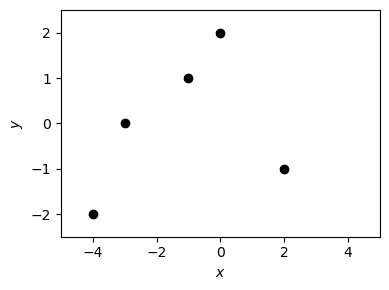

In [3]:
X_numpy, y_numpy = np.array([[-4], [-3], [-1], [0], [2]]), np.array([-2, 0, 1, 2, -1])

X = torch.tensor(X_numpy, dtype=torch.float32)
y = torch.tensor(y_numpy.reshape(-1, 1), dtype=torch.float32)

ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.set_xlim([-5, 5])
ax.set_ylim([-2.5, 2.5])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [118]:
def marginal_log_likelihood(y, X, model):
    N, _ = X.shape
    K = model.kernel(X, X)
    term1 = (N/2) * math.log(2 * math.pi)
    term2 = (1/2) * torch.logdet(K + model.stddev**2 * torch.eye(N))
    term3 = (1/2) * y.T @ torch.inverse(K + model.stddev**2 * torch.eye(N)) @ y
    log_evidence = - term1 - term2 - term3
    return log_evidence

def predictive_posterior(X_star, y, X, model):
    N, _ = X.shape
    N_star, _ = X_star.shape
    K = model.kernel(X, X)
    K_star = model.kernel(X, X_star)
    K_star_star = model.kernel(X_star, X_star)
    mu = K_star.T@torch.inverse(K + model.stddev**2 * torch.eye(N))@y
    
    # Use Cholesky decomposition for stability
    L = torch.linalg.cholesky(K + model.stddev**2 * torch.eye(N))
    alpha = torch.cholesky_solve(y, L)
    mu = K_star.T @ alpha
    
    v = torch.cholesky_solve(K_star, L)
    Sigma = K_star_star + model.stddev**2 * torch.eye(N_star) - K_star.T @ v
    # This ensures that a matrix that *should* be positive definite *is* positive definate.
    Sigma += 1e-3 * torch.eye(N_star)
    
    return torch.distributions.multivariate_normal.MultivariateNormal(loc=mu.view(-1), covariance_matrix=Sigma)

In [130]:
class GP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Hyperparameters
        self.lengthscale_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(math.sqrt(20)))))
        self.outputscale_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
        self.stddev_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(0.1))))
    
    def kernel(self, X, X_prime):
        K = self.outputscale**2 * torch.exp(-0.5 * (X - X_prime.T)**2 / self.lengthscale**2)
        return K
    
    @property
    def lengthscale(self):
        return torch.nn.functional.softplus(self.lengthscale_param)
    
    @property
    def outputscale(self):
        return torch.nn.functional.softplus(self.outputscale_param)
    
    @property
    def stddev(self):
        return torch.nn.functional.softplus(self.stddev_param)

model = GP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)

columns = ['epoch', 'loss', 'lengthscale', 'outputscale', 'stddev']
model_history_df = pd.DataFrame(columns=columns)

for epoch in range(10_000):
    optimizer.zero_grad()
    loss = -marginal_log_likelihood(y, X, model)
    loss.backward()
    optimizer.step()
    
    row = [epoch, loss.item(), model.lengthscale.item(), model.outputscale.item(), model.stddev.item()]
    model_history_df.loc[epoch] = row

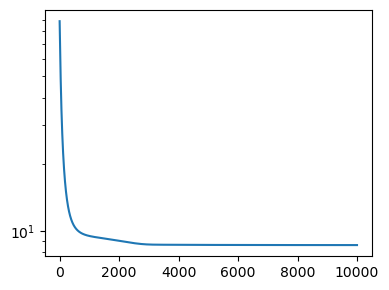

In [131]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(model_history_df.epoch, model_history_df.loss)
ax.set_yscale('log')
fig.tight_layout()
plt.show()

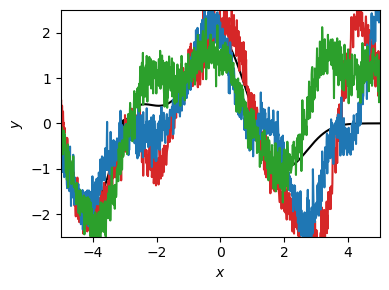

In [132]:
with torch.no_grad():
    X_star = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    dist = predictive_posterior(X_star, y, X, model)
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.plot(X_star.view(-1), dist.loc, color='#000000')
ax.plot(X_star.view(-1), dist.sample(), color='#D62728')
ax.plot(X_star.view(-1), dist.sample(), color='#1F77B4')
ax.plot(X_star.view(-1), dist.sample(), color='#2CA02C')
ax.set_xlim([-5, 5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [255]:
class RFF(GP):
    def __init__(self, in_features, out_features, rank=1024):
        super().__init__()
        # Hyperparameters
        self.lengthscale_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(20.0))))
        self.outputscale_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1.0))))
        self.stddev_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(0.1))))
        # RFFs
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.register_buffer('feature_weight', torch.randn(self.rank, self.in_features))
        self.register_buffer('feature_bias', 2 * torch.pi * torch.rand(self.rank))        
        self.sigma_param = torch.nn.Parameter(torch.tensor(1e-4))
        self.weight = torch.nn.Parameter(torch.empty(self.out_features, self.rank))
        bound = 1 / math.sqrt(self.weight.size(1))
        torch.nn.init.uniform_(self.weight, -bound, bound)

    def featurize(self, h):
        features = torch.nn.functional.linear(h, (1/self.lengthscale) * self.feature_weight, self.feature_bias)
        return (2/self.rank)**0.5 * torch.cos(features)
    
    def forward(self, h):
        features = self.outputscale * self.featurize(h)
        logits = torch.nn.functional.linear(features, self.weight + self.sigma * torch.randn_like(self.weight).to(self.weight.device))
        return logits
    
    def gaussian_nll_loss(self, logits, labels):
        batch_size, num_classes = logits.shape
        var = self.stddev**2 * torch.ones(batch_size).to(logits.device)
        return torch.nn.functional.gaussian_nll_loss(logits, labels, var)
        #return torch.nn.functional.mse_loss(logits, labels)
    
    def kernel(self, X, X_prime):
        return self.outputscale**2 * self.featurize(X)@self.featurize(X_prime).T
        
    @property
    def lengthscale(self):
        return torch.nn.functional.softplus(self.lengthscale_param)
    
    @property
    def outputscale(self):
        return torch.nn.functional.softplus(self.outputscale_param)
    
    @property
    def sigma(self):
        return torch.nn.functional.softplus(self.sigma_param)
    
    @property
    def stddev(self):
        return torch.nn.functional.softplus(self.stddev_param)


In [156]:
model = RFF(in_features=1, out_features=1, rank=1024)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0)

columns = ['epoch', 'loss', 'lengthscale', 'outputscale', 'stddev']
model_history_df = pd.DataFrame(columns=columns)

for epoch in range(10_000):
    optimizer.zero_grad()
    loss = -marginal_log_likelihood(y, X, model)
    loss.backward()
    optimizer.step()
    
    row = [epoch, loss.item(), model.lengthscale.item(), model.outputscale.item(), model.stddev.item()]
    model_history_df.loc[epoch] = row

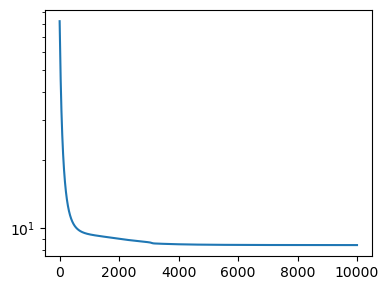

In [157]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(model_history_df.epoch, model_history_df.loss)
ax.set_yscale('log')
fig.tight_layout()
plt.show()

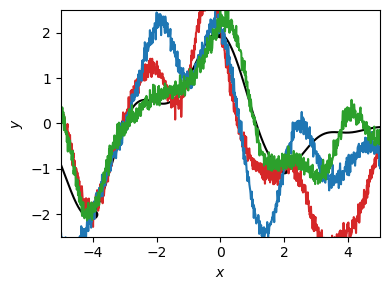

In [158]:
with torch.no_grad():
    X_star = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    dist = predictive_posterior(X_star, y, X, model)
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.plot(X_star.view(-1), dist.loc, color='#000000')
ax.plot(X_star.view(-1), dist.sample(), color='#D62728')
ax.plot(X_star.view(-1), dist.sample()s, color='#1F77B4')
ax.plot(X_star.view(-1), dist.sample(), color='#2CA02C')
ax.set_xlim([-5, 5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.tight_layout()
plt.show()

In [265]:
model = RFF(in_features=1, out_features=1, rank=1024)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=0.0)
criterion = losses.KappaELBoLoss(1.0, model.sigma_param, criterion=model.gaussian_nll_loss)

columns = ['epoch', 'loss', 'lengthscale', 'outputscale', 'stddev']
model_history_df = pd.DataFrame(columns=columns)

model.train()
for epoch in range(10_000):
    optimizer.zero_grad()
    params = model.weight.view(-1)
    logits = model(X)
    loss = criterion(y, logits, params, len(X))
    loss['loss'].backward()
    optimizer.step()
    
    row = [epoch, loss['loss'].item(), model.lengthscale.item(), model.outputscale.item(), model.stddev.item()]
    model_history_df.loc[epoch] = row

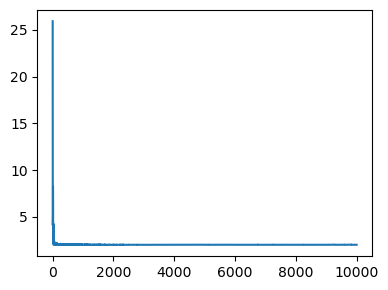

In [266]:
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.plot(model_history_df.epoch, model_history_df.loss)
#ax.set_yscale('log')
fig.tight_layout()
plt.show()

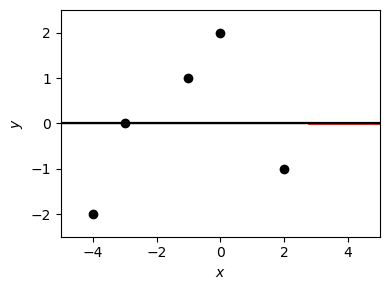

In [267]:
with torch.no_grad():
    X_star = torch.linspace(start=-5, end=5, steps=1000).view(-1, 1)
    samples = torch.stack([model(X_star).view(-1) for _ in range(100)])
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows, sharex=True, sharey='row')
ax.scatter(X_numpy, y_numpy, color='#000000')
ax.fill_between(X_star.view(-1), samples.mean(dim=0)+3*samples.std(dim=0), samples.mean(dim=0)-3*samples.std(dim=0), alpha=0.1, color='#000000')
ax.plot(X_star.view(-1), samples[0], color='#D62728')
ax.plot(X_star.view(-1), samples[1], color='#1F77B4')
ax.plot(X_star.view(-1), samples[2], color='#2CA02C')
ax.plot(X_star.view(-1), samples.mean(dim=0), color='#000000')
ax.set_xlim([-5, 5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
fig.tight_layout()
plt.show()